# TP1 - Prédiction du prix d'un diamant

On cherche à prédire le prix d'un diamant à partir d'un [dataset](https://www.kaggle.com/datasets/shivam2503/diamonds). Les informations dont on dispose sont :

* **price** : price in US dollars (\\$326-$18,823)
* **carat** : weight of the diamond (0.2-5.01)
* **cut** : quality of the cut (Fair, Good, Very Good, Premium, Ideal)
* **color** : diamond colour, from J (worst) to D (best)
* **clarity** : a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
* **x** : length in mm (0-10.74)
* **y** : width in mm (0-58.9)
* **z** : depth in mm (0-31.8)
* **depth** : total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43-79)
* **table** : width of top of diamond relative to widest point (43-95)

Le notebook que l'on présente est une proposition de correction, mais n'est clairement pas la totalité de ce que l'on peut faire. Il y a de nombreux points que l'on peut améliorer, ce notebook a plus une portée pédagogique que de performance.

Commençons par importer les données :

In [81]:
import numpy as np
import pandas as pd

df = pd.read_csv("TP1 - Diamants.csv")
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


On remarque une colonne qui ne sert à rien, supprimons-la.

**Consigne** : Supprimer la colonne *Unnamed: 0*

In [82]:
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## Qualité des données et exploration

Dans un premier temps, on veut s'assurer que les données avec lesquelles nous allons travailler soient saine. On veut supprimer les données qui sortent *vraiment* du lot, et déterminer les variables qui auront une importance (ou non) dans la prédiction. Nous n'allons pas découper le dataset en train/test car nous allons seulement mettre en place une validation croisée. Nous travaillerons donc pour le travail de nettoyage sur l'ensemble du dataset.

On commence par les données numériques, puis par les données catégorielles.

### Données numériques

La méthode *describe* d'un DataFrame permet d'avoir une vision haut niveau de la répartition dans le dataset.

In [83]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


Si on commence par regarder ce que l'on veut prédire, on note que la colonne *price* a une grande amplitude : de 326$ à 18823$. Sa moyenne est de l'ordre de 4000$, donc un bon modèle sera d'un ordre de grandeur inférieur. On note aussi un grand écart de valeur entre le troisième quantile et le maximum : cela pourrait se traduire par une grande variance dans les performances du modèles en validation croisée. Si les valeurs extrêmes sont présentes dans un pli de test, on peut avoir des écarts de performances fort.

Il est étonnant que le minimum pour les variables *x*, *y* et *z* soit 0 : d'après le descriptif, cela voudrait dire que nous avons des diamants en une à deux dimension au lieu de 3.

**Consigne** : Visualiser les lignes concernées.

In [84]:
print(df[df['price'] == df['price'].min()])
print()
print(df[df['price'] == df['price'].max()])
print()
print(df[df['x'] == 0])
print()
print(df[df['y'] == 0])
print()
print(df[df['z'] == 0])

   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31

       carat      cut color clarity  depth  table  price    x     y     z
27749   2.29  Premium     I     VS2   60.8   60.0  18823  8.5  8.47  5.16

       carat        cut color clarity  depth  table  price    x     y    z
11182   1.07      Ideal     F     SI2   61.6   56.0   4954  0.0  6.62  0.0
11963   1.00  Very Good     H     VS2   63.3   53.0   5139  0.0  0.00  0.0
15951   1.14       Fair     G     VS1   57.5   67.0   6381  0.0  0.00  0.0
24520   1.56      Ideal     G     VS2   62.2   54.0  12800  0.0  0.00  0.0
26243   1.20    Premium     D    VVS1   62.1   59.0  15686  0.0  0.00  0.0
27429   2.25    Premium     H     SI2   62.8   59.0  18034  0.0  0.00  0.0
49556   0.71       Good     F     SI2   64.1   60.0   2130  0.0  0.00  0.0
49557   0.71       Good     F     SI2

**Consigne** : Ces données-là n'ayant pas de sens dans notre contexte, supprimer ces lignes et mesurer la taille du dataset avant et après la suppression.

In [85]:
print(df.shape)
df=df[df['price'] != df['price'].min()]
df=df[df['price'] != df['price'].max()]
df=df[df['x'] != 0]
df=df[df['y'] != 0]
df=df[df['z'] != 0]
print(df.shape)

(53940, 10)
(53917, 10)


**Consigne** : Vérifier à nouveau les statistiques du dataset puis commenter.

In [86]:
df.describe()

,carat,depth,table,price,x,y,z
count,53917.000000,53917.000000,53917.000000,53917.000000,53917.000000,53917.000000,53917.000000
mean,0.797692,61.749572,57.456767,3930.850752,5.731643,5.734904,3.540060
std,0.473752,1.432340,2.234022,3986.815093,1.119336,1.140042,0.702479
min,0.200000,43.000000,43.000000,327.000000,3.730000,3.680000,1.070000
25%,0.400000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5323.000000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18818.000000,10.740000,58.900000,31.800000


Il n'y a plus des lignes avec x/y/z égale 0
Les valeurs min/max de colonne 'price' sont réduites un peu

On souhaite visualiser le tableau précédent. Nous proposons de constuire une fonction qui va visualiser :
1. La distribution d'une variable
2. La distribution de la variable d'intérêt *price* par rapport à la variable que l'on étudie

**Consigne** : Construire une fonction `explore_column` qui prend en paramètre :
* *df* : le dataframe qui contient les colonnes que l'on souhaite visualiser
* *column* : le nom de la colonne que l'on souhaite visualiser
* *target_column* : le nom de la colonne cible (ici *price*)

Cette fonction affichera côte à côte l'histogramme de la colonne ainsi que le scatter-plot entre cette colonne et la colonne cible.

In [87]:
import seaborn as sns

import matplotlib.pyplot as plt

def explore_column(df, column, target_column):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    sns.histplot(df[column], kde=True, ax=axes[0])
    axes[0].set_title(f'Distribution of {column}')
    
    sns.scatterplot(data=df, x=column, y=target_column, ax=axes[1])
    axes[1].set_title(f'{column} vs {target_column}')
    
    plt.tight_layout()
    plt.show()

Exploitons cette fonction pour la colonne *y* :

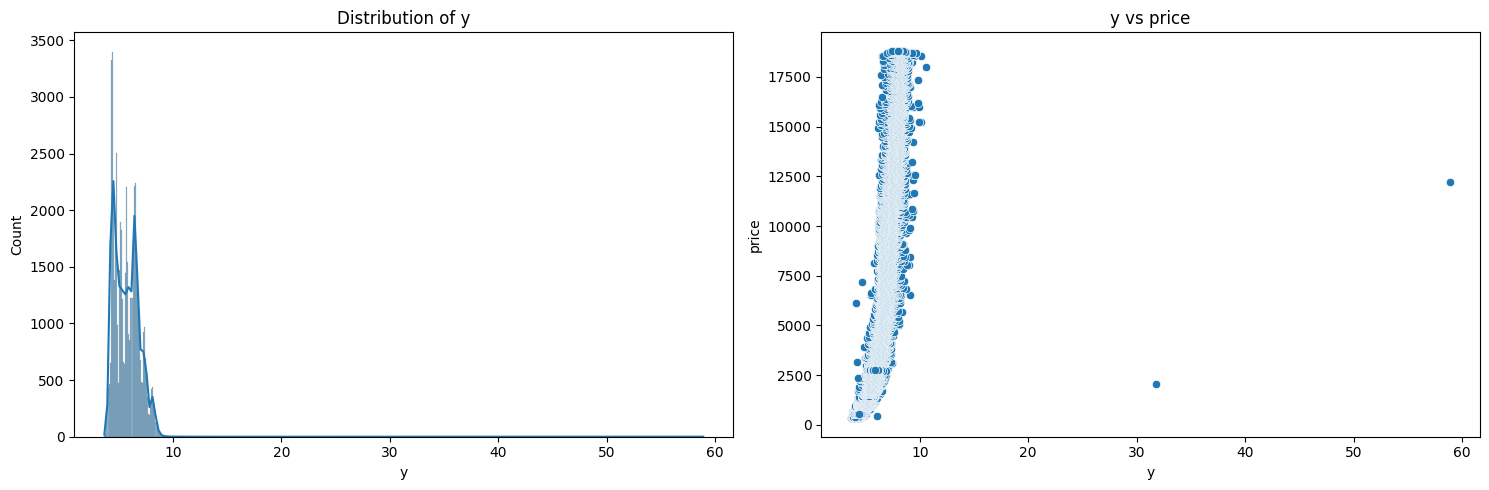

In [88]:
explore_column(df, "y", "price")

On voit clairement que nous avons deux observations qui sont très éloignées du reste des observations. De plus, ces observations ne sont pas dans la *tendance* que l'on observe entre la variable *y* et la variable *price*. Nous devons donc supprimer ces deux observations car elles vont empêcher le modèle de bien apprendre.

**Consigne** : Supprimer les deux observations et afficher la taille avant et après suppression du dataset.

In [89]:
print(df.shape)
outliers = df[(df['y'] > 30)]

df = df.drop(outliers.index)
print()
print(df.shape)

(53917, 10)

(53915, 10)


**Consigne** : Visualiser à nouveau la colonne *y* avec la fonction `explore_column` et commenter.

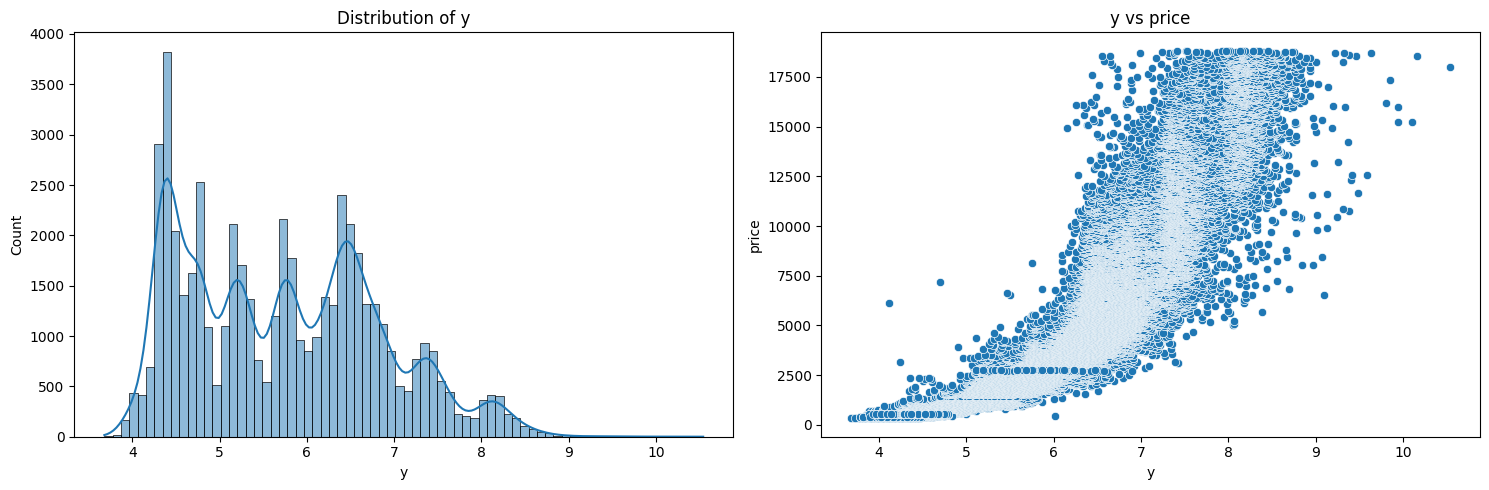

In [93]:
explore_column(df, "y", "price")

Les 2 outliers étaient effacés
Les 2 histogrammes sont zoomés dans l'intervale de 0 à 10, et on peut voir plus clairement les points

**Consigne** : Reproduire l'étude sur le reste des colonnes numériques.

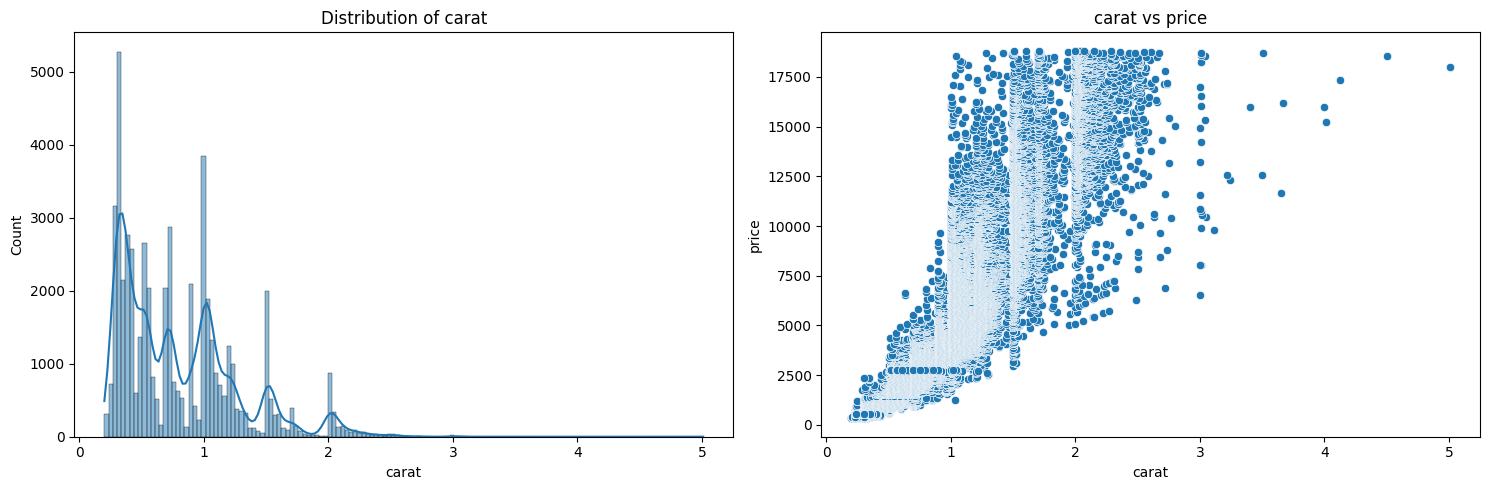

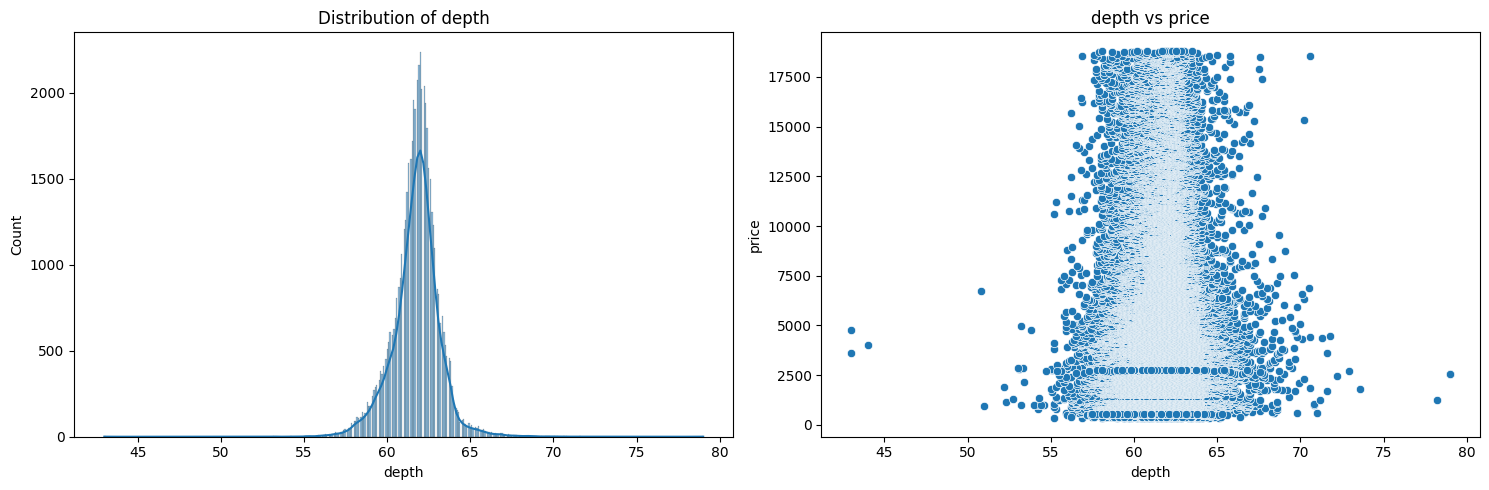

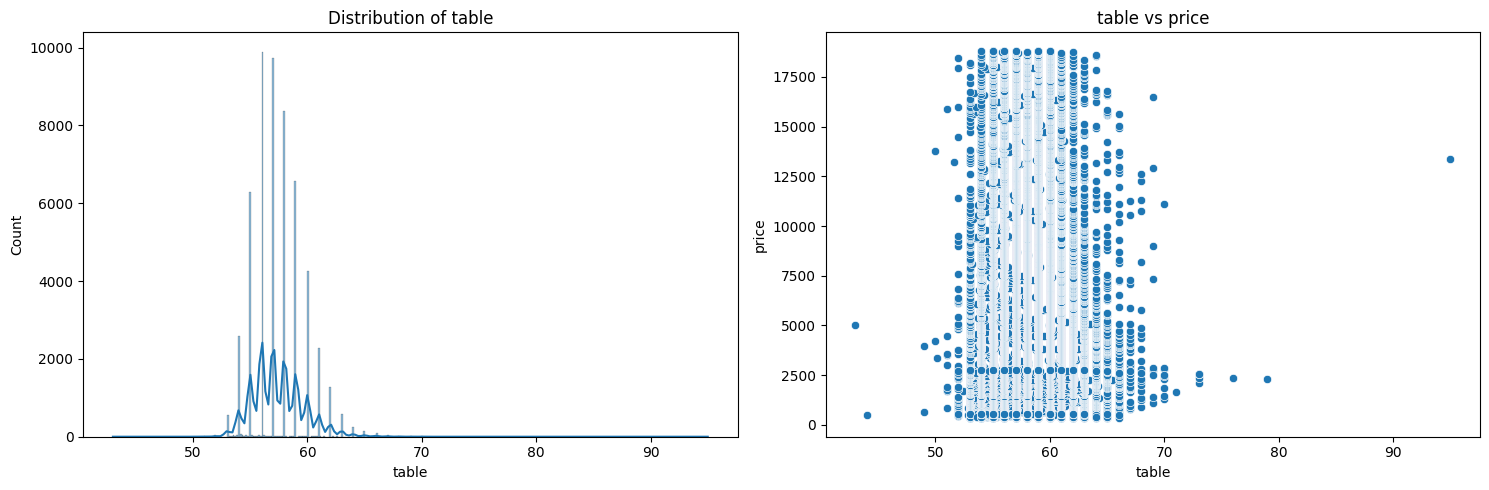

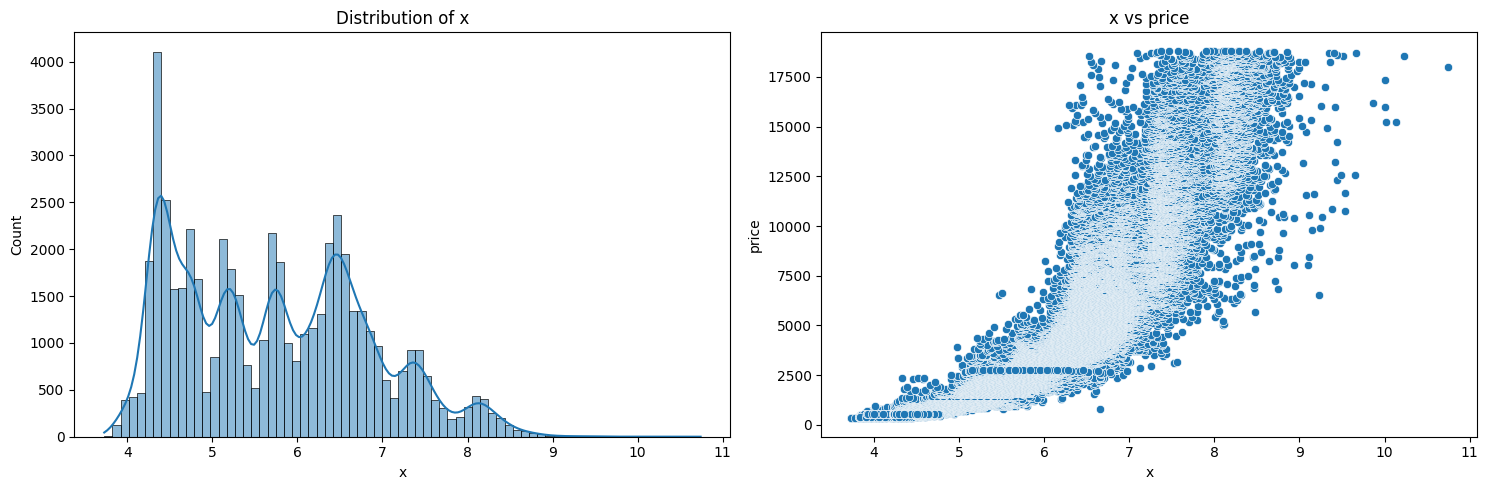

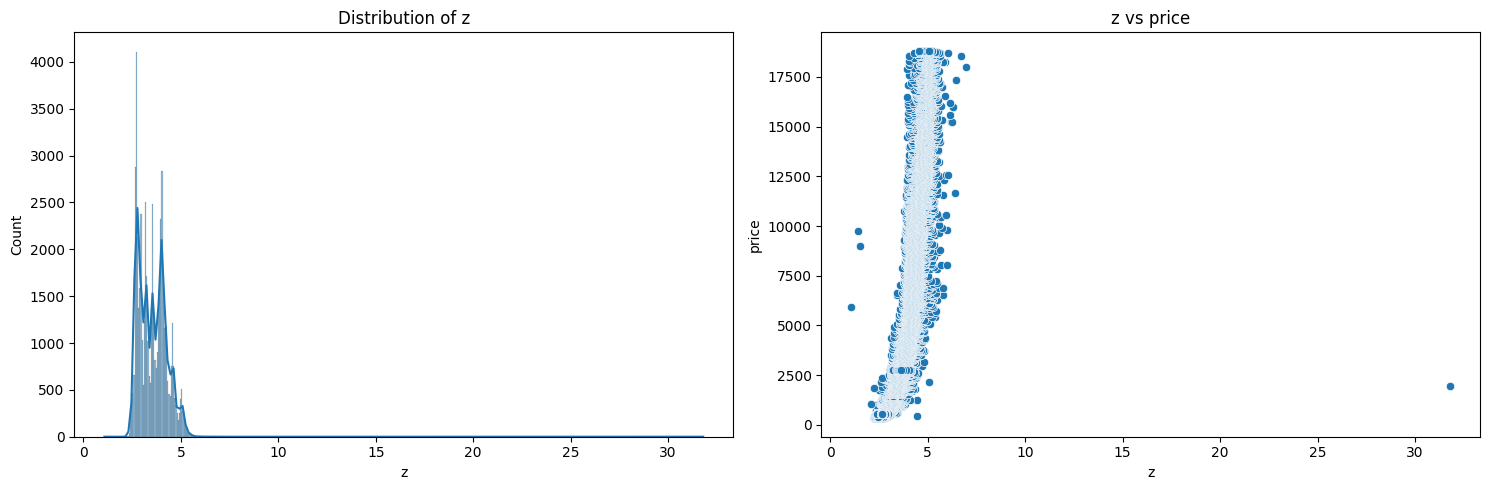

In [95]:
numeric_columns = ["carat", "depth", "table", "x", "z"]

for column in numeric_columns:
    explore_column(df, column, "price")

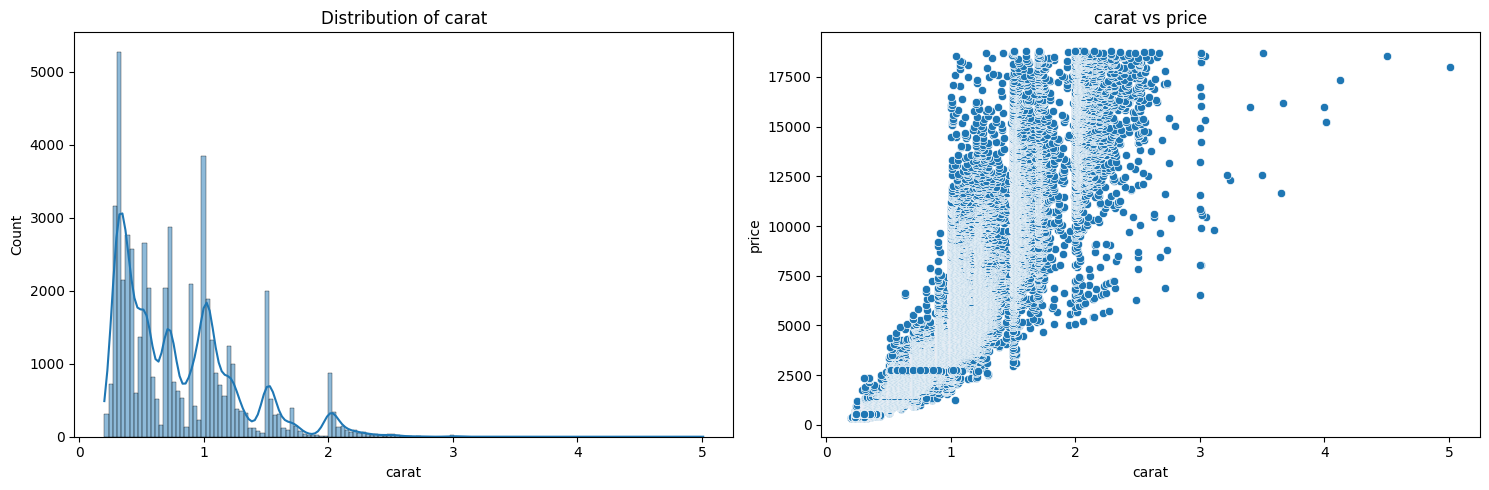

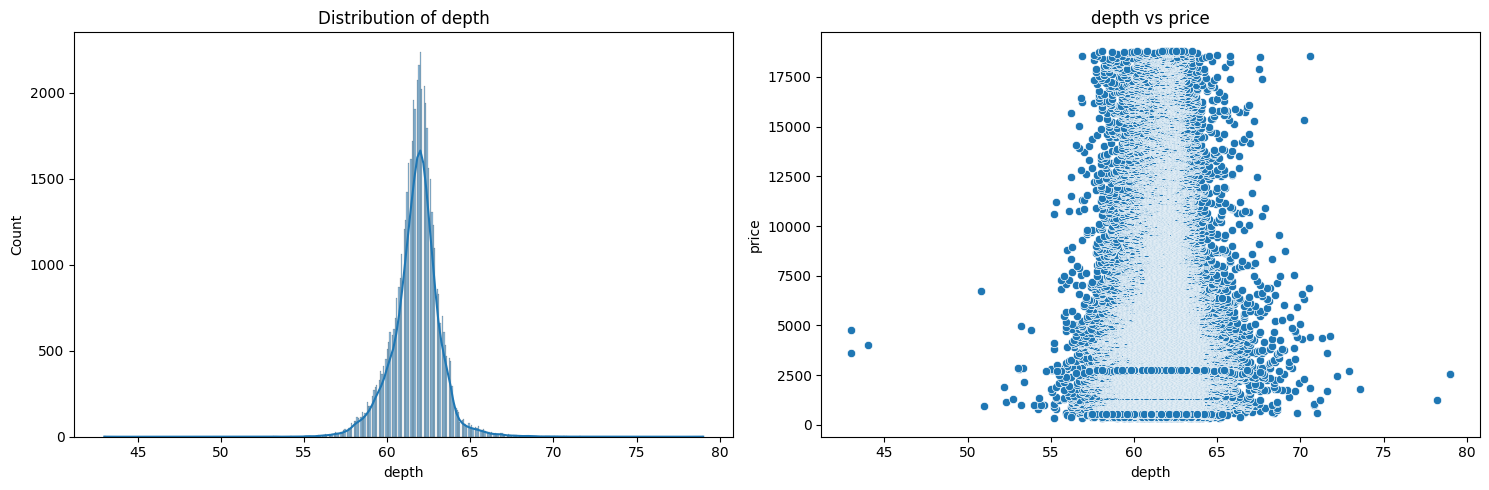

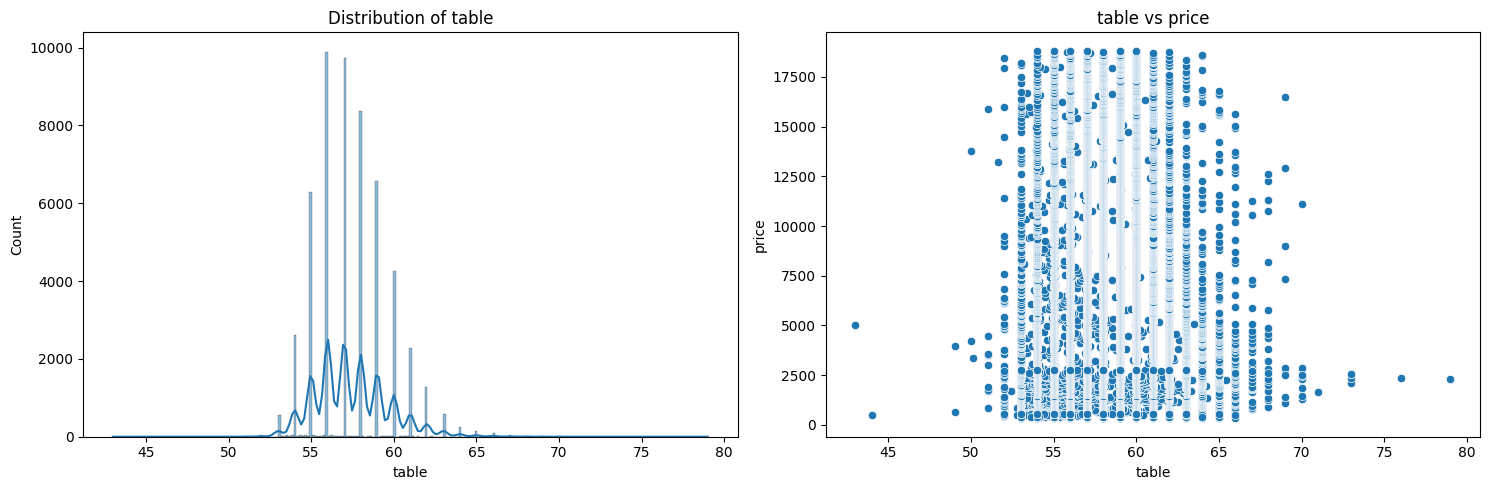

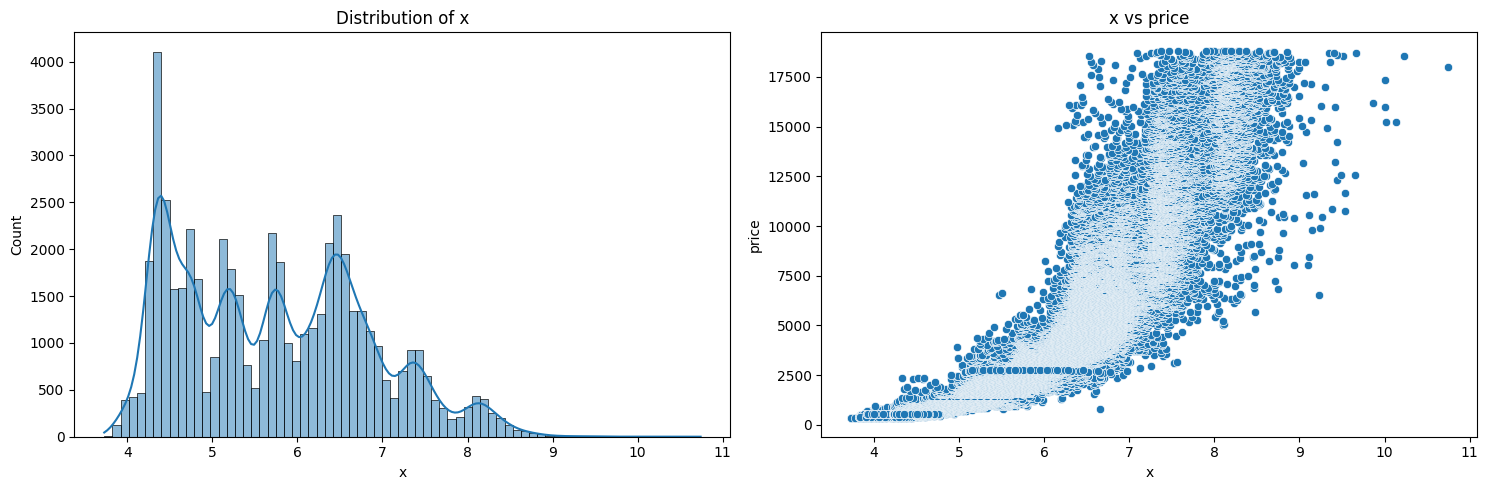

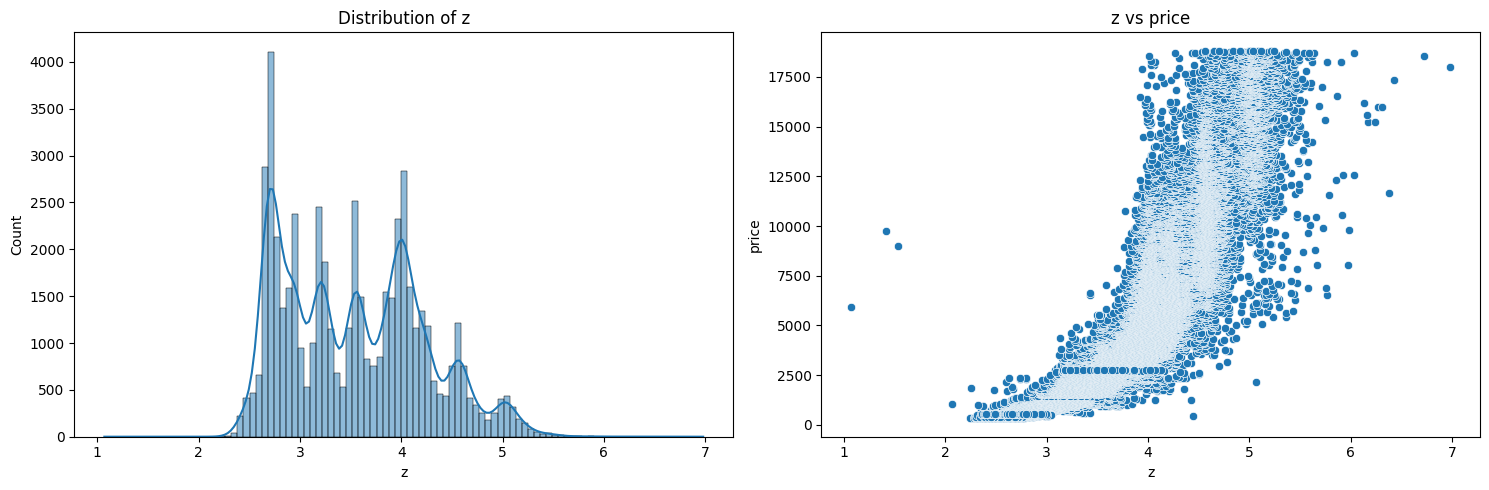

In [96]:
df = df.drop(df[(df['table'] > 90)].index)
df = df.drop(df[(df['z'] > 30)].index)
for column in numeric_columns:
    explore_column(df, column, "price")

### Données catégorielles

Pour étudier la distributions des données catégorielles, on se propose de visualiser des *violin plot* :

In [97]:
def make_violin_plot(column, figsize=(15, 8)):
    plt.figure(figsize=figsize)
    sns.violinplot(data=df, x="price", y=column, inner=None)
    plt.title("Distribution of price in function of %s" % column.capitalize())
    plt.show()

Commençons avec la colonne *clarity* :

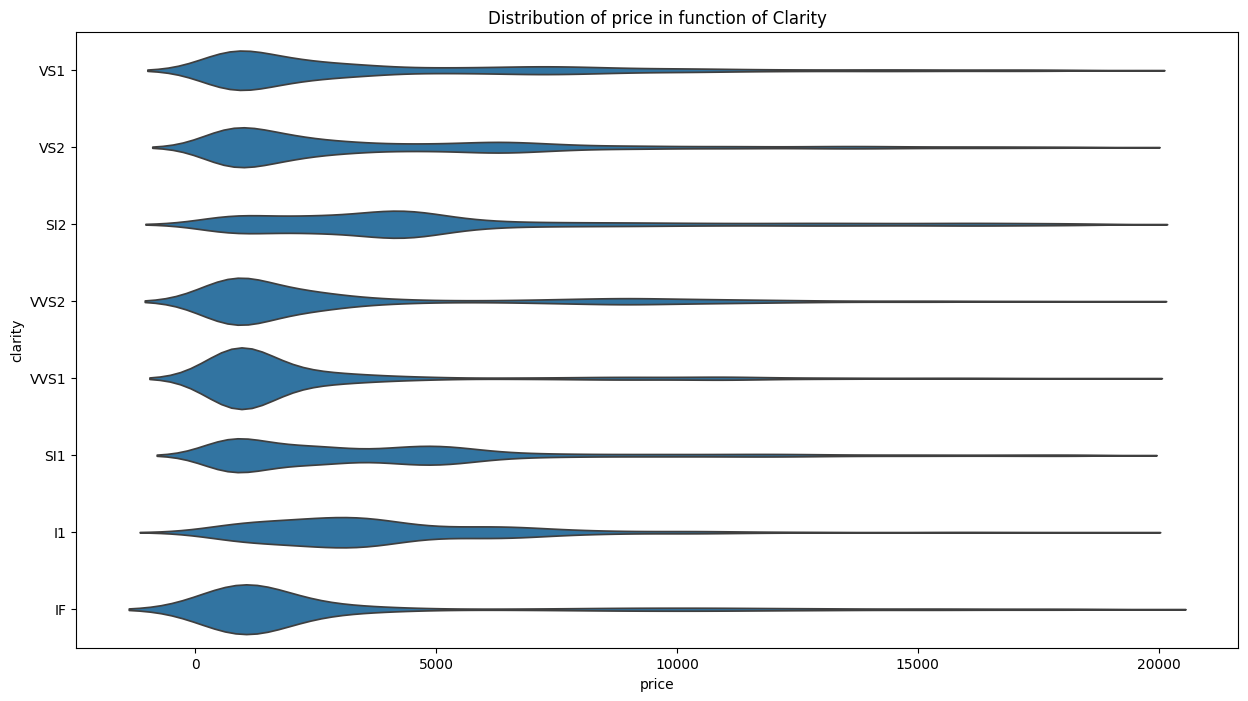

In [98]:
make_violin_plot("clarity")

On note que la valeur *SI2* et *I1* on des formes bien différentes du reste qui sont plus concentrées. A nouveau, nous ne présentons pas l'ensemble des graphiques. Dans l'ensemble, il n'y a pas de grandes tendances qui se dessinent.
Nous ne pouvons pas exploiter les données catégorielles directement : nous allons réaliser un *one hot encoding* pour pouvoir les utiliser dans notre régression linéaire.

**Consigne** : À l'aide de la fonction [`pd.get_dummies`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html), faire un *one hot encoding* des données.

In [99]:
df_encoded = pd.get_dummies(df, columns=['cut', 'color', 'clarity'])
df_encoded.head()

,carat,depth,table,price,x,y,z,cut_Fair,cut_Good,cut_Ideal,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
2,0.23,56.9,65.0,327,4.05,4.07,2.31,False,True,False,...,False,False,False,False,False,False,True,False,False,False
3,0.29,62.4,58.0,334,4.20,4.23,2.63,False,False,False,...,True,False,False,False,False,False,False,True,False,False
4,0.31,63.3,58.0,335,4.34,4.35,2.75,False,True,False,...,False,True,False,False,False,True,False,False,False,False
5,0.24,62.8,57.0,336,3.94,3.96,2.48,False,False,False,...,False,True,False,False,False,False,False,False,False,True
6,0.24,62.3,57.0,336,3.95,3.98,2.47,False,False,False,...,True,False,False,False,False,False,False,False,True,False


## Modélisation

Nous avons maitenant un dataset nettoyé avec une première idées des éventuelles données qui seront utiles. Nous allons créer plusieurs modélisations et mesurer les performances. Pour se faciliter la tâche, nous allons construire une fonction pour le faire.

Cette fonction va réaliser une validation croisé puis afficher les performances. Notre métrique sera la RMSE en priorité et nous exploiterons également le $R^2$ pour avoir un éclairage différent. 
Nous utiliserons la fonction [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) pour réaliser la validation croisé. Pour avoir les métriques que l'on souhaite, il faut que l'on utilise la fonction [`make_scorer`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) pour avoir le bon format d'appel dans la fonction [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [100]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression


def train_predict(X, y, name, metric=mean_squared_error, cv=5):
    model = LinearRegression()
    scores = cross_val_score(model, X, y, scoring=make_scorer(metric), cv=cv)
    mean_scores = np.mean(scores)
    std_scores = np.std(scores)
    print("%s : %0.4f (+/- %0.4f)" % (name, mean_scores, std_scores))

**Consigne** : Définir la fonction `RMSE`.

## Baseline

Nous avons réaliser un travail de nettoyage, essayons de mesurer l'apport de chaque partie. Autrement dit, quelles performances atteint-on si :

* On utilise la totalité du dataset initial (donc avec les valeurs extrêmes) mais uniquement les données numériques ?
* On utilise la totalité du dataset initial (donc avec les valeurs extrêmes) et aussi les données numériques ?
* On utilise le dataset sans les valeurs extrêmes mais uniquement les données numériques ?
* On utilise le dataset sans les valeurs extrêmes et aussi les données numériques ?

**Consigne** : Définir une fonction `preprocessing` qui prend en paramètre :
* *remove_outliers*: booléen indiquant s'il faut supprimer les lignes identifiées comme outliers
* *get_categorical*: booléen indiquant s'il faut utiliser ou non les données catégorielles
Cette fonction renvoie la matrice d'information $X$ et le vecteur cible $y$. La fonction chargera à chaque appel le dataset initial.

**Consigne** : À l'aide de la fonction `preprocessing` précédente, réaliser les quatres comparaisons souhaitées puis commenter.

### Améliorations

On souhaite réduire la variance. Une solution sera de régulariser le modèle en réalisant une régression Ridge ou Lasso par exemple. Avant de changer d'algorithme, on veut essayer de tirer profit des remarques que l'on a fait pendant la partie d'exploration des données.

Nous avions noté que la variable $y$ était *lié* au prix avec une tendance de la forme $x\mapsto x^2$. Essayons d'ajouter $y^2$ et mesurons la performance.

**Consigne** : Ajouter la colonne $y^2$ au dataset issu de la fonction `preprocessing` avec l'ensemble des informations. Puis entraîner un modèle avec `train_predict` puis commenter.

**Consigne** : Reproduire ce travail avec l'ensemble des remarques faites dans la partie exploration des données.

### Régression Ridge

Nous ne travaillerons qu'avec la régression Ridge car l'intérêt de sélection des variables de la méthode LASSO n'est pas primordiale ici : nous avons *peu* d'informations au regard du nombre d'observations. Cela reste tout de même un exercice que l'on peut réaliser pour s'en convaincre.

Nous allons entraîner un ensemble de régression Ridge avec à chaque fois une valeur de pénalisation différente pour identifier la meilleure valeur de $\lambda$.

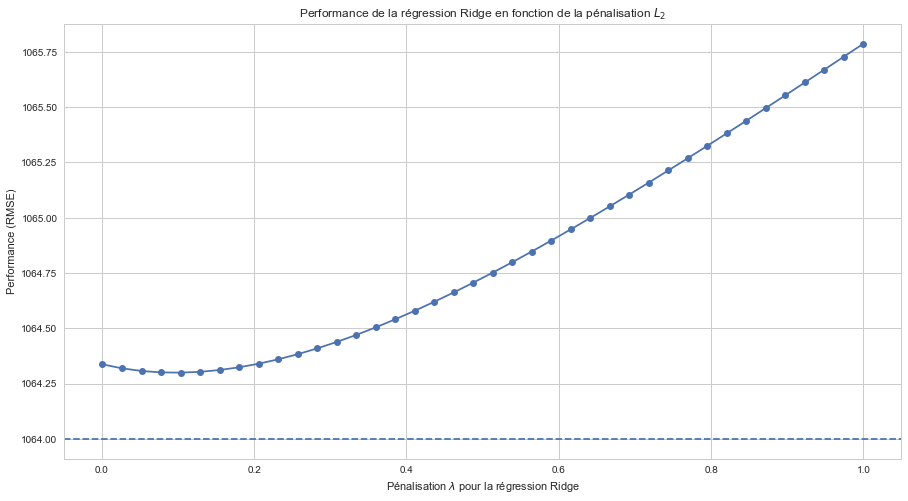

In [22]:
from sklearn.linear_model import Ridge

alpha_grid = np.linspace(0.001, 1, 40)
score_result = []
for alpha in alpha_grid:
    model = Ridge(alpha=alpha)
    scores = cross_val_score(model, X, y, scoring=make_scorer(RMSE), cv=10)
    score_result.append(scores.mean())


plt.figure(figsize=(15, 8))
plt.plot(alpha_grid, score_result, 'o-')
plt.axhline(y=1064, ls='--')
plt.xlabel(r"Pénalisation $\lambda$ pour la régression Ridge")
plt.ylabel("Performance (RMSE)")
plt.title(r"Performance de la régression Ridge en fonction de la pénalisation $L_2$")
plt.show()

On a tracé en pointillé la valeur obtenue par la régression Ridge : on obtient pas une meilleure valeur en RMSE. Vérifions si on obtient une variance réduite pour le meilleure $\lambda$ qui semble être 0.1

**Consigne** : Entraîner une régression Ridge avec le $\lambda$ adapté puis commenter.

## Etude des résultats

On souhaite avoir une meilleure *compréhension* de notre modèle. Le meilleur que nous ayons construit est entraîné à partir de données traités et augmenté. Entraînons-le sur un dataset de test et mesurons ses performances sur un jeu de test.

In [24]:
from sklearn.model_selection import train_test_split

X, y = preprocessing(remove_outliers=True, get_categorical=True)
X["x^2"] = X["x"]**2
X["y^2"] = X["y"]**2
X = X.drop(columns=["depth"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)
print("RMSE : %0.4f" % RMSE(y_test, y_pred))

RMSE : 1063.6756


**Consigne** : Visualiser les distribution de *y_test* et *y_pred* à l'aide de la fonction [`plt.hist`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html) puis commenter.

**Consigne** : À partir d'une liste de 10 seuils pour la valeur à prédire (ici le *y_test*), mesurer la qualité de prédiction du modèle à l'aide de la fonction `RMSE` selon ces tranches.

**Consigne** : À partir d'une liste de 10 seuils pour la valeur prédite (ici *y_pred*), mesurer la qualité de prédiction du modèle à l'aide de la fonction `RMSE` selon ces tranches. Commenter ce résultat et le précédent.